## SGZH sentiment data parsing and posts filtering

### Module imports

In [1]:
import os, sys, re
from tqdm import tqdm
import sqlite3
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import importlib
import scripts.post_parser

importlib.reload(scripts.post_parser)
print('modules reloaded!')

from scripts.post_parser import TinkoffPulseParser

modules reloaded!


In [2]:
current_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(current_dir)
database_path = os.path.join(project_root, 'databases', 'sgzh_posts_2023.db')

### T-Pulse posts parsing

In [2]:
# custom_db = "sgzh_posts_2023.db"
# parser = TinkoffPulseParser(
#     start_date='2023-01-01',
#     db_name=custom_db
# )
# parser.parse_single_ticker("SGZH")

Обрабатывается дата: 2023-01-10T05:57:23.913Z
Получено постов: 66601


2025-03-01 15:55:24,319 - INFO - Достигнута целевая дата 2023-01-01 00:00:00+00:00


### EDA

In [3]:
conn = sqlite3.connect(database_path)
sgzh_posts_2023 = pd.read_sql_query("SELECT * FROM tcs_pulse_posts", conn)

In [4]:
sgzh_posts_2023.head(3)

,id,post_id,inserted,instruments,hashtags,content,reactions_count,comments_count,parse_dt
0,1,479d8c65-65fb-40ae-8c2e-ede45b1470e3,2025-03-01T10:14:35.557Z,SGZH,None,{$SGZH},0,0,2025-03-01 13:19:02
1,2,986f79ed-7a2a-4028-8d34-52794041a3fa,2025-03-01T10:03:01.236Z,"MTLR, SGZH, MVID, ORUP, AMEZ, ZILLP, OKEY, CAR...",None,Приветствую! Хочу собрать портфель из интересн...,1,2,2025-03-01 13:19:02
2,3,ef5378da-84f5-40ad-a13c-b6ea4feeab67,2025-03-01T09:26:49.983Z,"ELFV, PIKK, NKNC, ROSN, PLZL, MDMG, DATA, YDEX...","теханализ, акции, хочу_в_дайджест, трейдинг, р...",Недельный отчет по публикациям: WEEK_75\nЗа пр...,2,1,2025-03-01 13:19:02


Преобразуем дату и посмотрим на динамику публикаций

In [5]:
sgzh_posts_2023['inserted'] = pd.to_datetime(sgzh_posts_2023["inserted"].str[:10])
daily_counts_sgzh = sgzh_posts_2023.groupby('inserted').size().reset_index(name='count')

In [6]:
%load_ext autoreload
%autoreload 2
from scripts.vizualizer import plot_daily_posts


plot_daily_posts(daily_counts_sgzh, "SGZH")

Сохраним общее число публикаций на каждый день будем использовать как дополнительный признак в модели:

In [7]:
sgzh_posts_2023["total_day_posts_cnt"] = sgzh_posts_2023.groupby(by="inserted")[
    "id"
].transform("count")

Также нам важно понимать распределение длин текстов:

In [8]:
sgzh_posts_2023['words_cnt'] = sgzh_posts_2023['content'].apply(lambda x: len(x.split()))
sgzh_posts_2023['post_len'] = sgzh_posts_2023['content'].apply(len)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


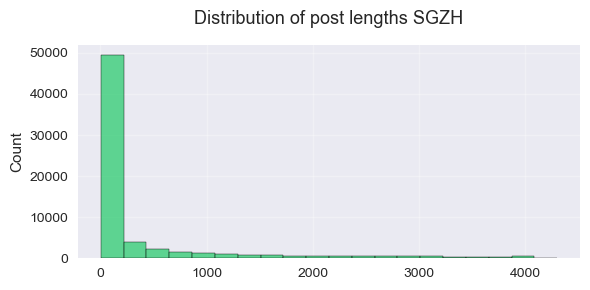

In [9]:
%load_ext autoreload
%autoreload 2
from scripts.vizualizer import plot_posts_length

plot_posts_length(sgzh_posts_2023, 'SGZH', 'post_len', '')

### Content processing

In [10]:
%load_ext autoreload
%autoreload 2
from scripts.post_processer import preprocess_text_base

tqdm.pandas()
sgzh_posts_2023['content_base'] = sgzh_posts_2023['content'].progress_apply(preprocess_text_base)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 66756/66756 [00:00<00:00, 160191.55it/s]


In [11]:
sgzh_posts_2023["instruments"] = sgzh_posts_2023["instruments"].fillna("error")

sgzh_posts_2023["tags"] = 0
sgzh_posts_2023["tags"] = sgzh_posts_2023["instruments"].apply(
    lambda x: ", ".join(sorted(x.split(", ")))
)

In [12]:
sgzh_posts_2023['tags'].value_counts(normalize=True)

SGZH                                                      0.808542
AFKS, SGZH                                                0.006816
MTLR, SGZH                                                0.001813
GAZP, SGZH                                                0.001693
MVID, SGZH                                                0.001213
                                                            ...   
RENI, SGZH, UGLD                                          0.000015
BANEP, MTLRP, OZON, SGZH                                  0.000015
AFKS, ASTR, MTSS, SBER, SBERP, SGZH, SNGSP, SVCB, VTBR    0.000015
LKOH, MAGN, MGNT, PIKK, RTKM, SGZH                        0.000015
ALRS, LSNG, MSNG, SGZH                                    0.000015
Name: tags, Length: 8739, dtype: float64

In [13]:
sgzh_posts_2023['sgzh_only'] = sgzh_posts_2023['tags'].apply(lambda x: 1 if x == 'SGZH' else 0)

In [15]:
sgzh_posts_2023['content_base'].sample(250).to_excel('sgzh_posts.xlsx', encoding="utf-8", index=False)

In [17]:
ticker = 'SGZH'
segezha_patterns = [
    r"\{\$SGZH\}",  # Ticker symbol in posts
    r"Сегеж(?:а|и|е|у)?(?:\s*Груп)?",  # Company name variations
    r"Segezha(?:\s*Group)?",  # English name
    r"деревяшка",  # Informal reference
    r"Сереж(?:а|и|е|у|ка)",  # Informal nickname variations
    r"Сергей",  # Another informal reference
]

In [18]:
%load_ext autoreload
%autoreload 2

from scripts.post_processer import preprocess_other_tickets

# 2
tqdm.pandas()
sgzh_posts_2023["processed_posts"] = sgzh_posts_2023.progress_apply(
    lambda df: (
        preprocess_other_tickets(df["content_base"], ticker, segezha_patterns)
        if df["sgzh_only"] == 0
        else df["content_base"]
    ),
    axis=1,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 66756/66756 [00:03<00:00, 21944.05it/s]


In [21]:
%load_ext autoreload
%autoreload 2

from scripts.post_processer import clean_promotional_content

# 3
tqdm.pandas()
sgzh_posts_2023["processed_posts"] = sgzh_posts_2023["processed_posts"].progress_apply(
    lambda x: clean_promotional_content(x)
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 66756/66756 [04:49<00:00, 230.36it/s]


In [22]:
%load_ext autoreload
%autoreload 2

from scripts.post_processer import mark_ticker_only_posts

# 4
sgzh_posts_2023 = mark_ticker_only_posts(sgzh_posts_2023)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 66756/66756 [00:00<00:00, 86844.89it/s]


In [23]:
sgzh_posts_2023['ticker_only'].value_counts()

0    64406
1     2350
Name: ticker_only, dtype: int64

In [24]:
sgzh_posts_processed = sgzh_posts_2023[sgzh_posts_2023['ticker_only'] != 1]

In [28]:
req_cols = [
    "post_id",
    "inserted",
    "tags",
    "hashtags",
    "processed_posts",
    "reactions_count",
    "comments_count",
    "total_day_posts_cnt",
]

sgzh_upload = sgzh_posts_processed[req_cols].reset_index(drop=True)

In [29]:
save_path = os.path.join(project_root, 'processed_data', 'sgzh_processed_full.xlsx')
sgzh_upload.to_excel(save_path, encoding="utf-8", index=False)

Готовим выборку:

In [30]:
sgzh_post_id = sgzh_upload[['post_id', 'processed_posts']]

In [31]:
sgzh_train, sgzh_val = sgzh_post_id[3000:], sgzh_post_id[:3000]

sgzh_llm, sgzh_val = sgzh_val[:2500], sgzh_val[2500:]

In [32]:
save_path_train = os.path.join(project_root, 'processed_data', 'sgzh_train.xlsx')
save_path_llm = os.path.join(project_root, 'processed_data', 'sgzh_llm.xlsx')
save_path_val = os.path.join(project_root, 'processed_data', 'ssgzh_val.xlsx')

sgzh_train.to_excel(save_path_train, encoding="utf-8", index=False)
sgzh_llm.to_excel(save_path_llm, encoding="utf-8", index=False)
sgzh_val.to_excel(save_path_val, encoding="utf-8", index=False)